In [169]:
#-------------------------------------------------------------------------
# INSTALAMOS LA LIBRERÍA gymnasium
#-------------------------------------------------------------------------
!pip install gymnasium

# **1. Entender el entorno**

---


Se usará el taxi-v3 del entorno ginmasio de OpenAI.

* El entorno OpenAI Gym Taxi-v3 es un problema clásico de aprendizaje por refuerzo que se utiliza a menudo para aprender y probar algoritmos RL. En este entorno, el agente controla un taxi que navega en un mundo en red, para recoger a un pasajero de un lugar y dejarlo en otro.
* La matriz de funcionamiento consistirá en 5 * 5 celdas.
* El taxista se muestra con un fondo amarillo.
* Las paredes se representarán meidante líneas verticales.
* El objetivo es mover el taxi a la ubicación del pasajero (de color azul), recoger al pasajero, trasladarse al destino deseado del pasajero (de color violeta) y dejar al pasajero.
* El agente recibe las siguientes recompensas:
 * +20 por dejar con éxito al pasajero.
 * -10 por cada intento fallido de recoger o dejar al pasajero.
 * -1 por cada paso dado por el agente, con el objetivo de incentivarlo a tomar una ruta eficiente.


In [188]:
#-------------------------------------------------------------------------
# IMPORTAMOS LA LIBRERÍA gymnasium Y MOSTRAMOS EL ENTORNO
#-------------------------------------------------------------------------
import gymnasium as gym
entorno = gym.make( 'Taxi-v3', render_mode = 'ansi' )
entorno.reset()

print( entorno.render() )

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+






*   La línea gym.make('Taxi-v3′, render_mode='ansi') crea una instancia del entorno Taxi-v3. El argumento render_mode=’ansi’ especifica que el modo de representación será el modo ANSI, que es un modo basado en texto adecuado para mostrar el entorno en una consola de texto.
*   Se llama al método entorno.reset() para restablecer el entorno a su estado inicial. Por lo general, esto se hace al comienzo de cada episodio para comenzar de nuevo.

# **2. Crear el agente de q-aprendizaje**


*   Initialización (método __init__):
 * entorno: Entorno en el que opera el agente.
 * tasaAprendizaje: Tasa de aprendizaje para actualizar los valores Q.
 * epsilonInicial: Tasa de exploración inicial.
 * epsilonDecremento: Velocidad en la que disminuye la tasa de exploración.
 * epsilonFinal: Tasa mínima de exploración.
 * factorDecremento: Factor de descuento para recompensas futuras.
*   Método obtener_accion:
 * Con probabilidad ε, elige una acción aleatoria (exploración).
 * Con probabilidad 1-ε, elige la acción con el valor Q más alto para la observación actual (explotación).
 * Este valor es alto inicialmente y se reduce gradualmente.
*   Método update:
 * Actualiza el valor Q según la recompensa observada y el valor Q máximo del siguiente estado.
*   Método decay_epsilon:
 * disminuye la tasa de exploración (épsilon) hasta alcanzar su valor final.

In [191]:
#-------------------------------------------------------------------------
# IMPORTAMOS MÁS LIBRERÍAS NECESARIAS Y CREAMOS LA CLASE QAprendizajeAgente
#-------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class QAprendizajeAgente:
    #---------------------------------------------------------------------
    # Inicializamos la clase QAprendizajeAgente
    #---------------------------------------------------------------------
    def __init__( self, entorno, tasaAprendizaje, epsilonInicial, epsilonDecremento, epsilonFinal, factorDecremento = 0.95 ):
        self.env              = entorno
        self.learning_rate    = tasaAprendizaje
        self.discount_factor  = factorDecremento
        self.epsilon          = epsilonInicial
        self.epsilon_decay    = epsilonDecremento
        self.final_epsilon    = epsilonFinal

        # Inicializamos un diccionario vacío de valores de acción de estado
        self.q_values = defaultdict( lambda: np.zeros( entorno.action_space.n ) )

    #---------------------------------------------------------------------
    # Obtenemos la acción a desarrollar a partir del estado (posición) en
    # el que se halle el vehículo (Taxi)
    #---------------------------------------------------------------------
    def obtenerAccion( self, estado ) -> int:
        x = np.random.rand()
        if x < self.final_epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax( self.q_values[ estado ] )

    #---------------------------------------------------------------------
    # Actualizamos los datos del nuevoQ
    #---------------------------------------------------------------------
    def actualizar( self, estado, accion, recompensa, fin, siguienteEstado ):
        if not fin:
            nuevoQ = np.max( self.q_values[ siguienteEstado ] )
            self.q_values[ estado ][ accion ] += self.learning_rate * \
                ( recompensa + self.discount_factor * nuevoQ - self.q_values[ estado ][ accion ])

    #---------------------------------------------------------------------
    # Decrementamos epsilon en función de la tasa de esploración de épsilon
    #---------------------------------------------------------------------
    def decrementarEpsilon( self ):
        self.epsilon = max( self.final_epsilon, self.epsilon - self.epsilon_decay )

# **3. Definición del método de entrenamiento**

*   La función entrenarAgente es responsable de entrenar al agente Q-learning proporcionado en un entorno determinado durante un número específico de episodios.

*   Cada episodio es una iteración hasta que el agente comete un error que conduce a la terminación o completa la entrega con éxito.

*   La función itera a través del número especificado de episodios (episodios).

*   Episodio de Inicialización:
 * Restablece el entorno e inicializa variables para seguir el progreso del episodio.
* Dentro de cada episodio, el agente:
 * Selecciona acciones basadas en el método definido en nuestra clase de agente,
 * Interactúa con el entorno,
 * actualiza los valores Q y acumula recompensas hasta que termina el episodio.
* Disminución de Epsilon:
 * Después de cada episodio, la tasa de exploración del agente (épsilon) se reduce utilizando el método decay_epsilon.
 * Inicialmente, el valor épsilon es alto, lo que lleva a una mayor exploración.
 * Esto se reduce a 0,1 en la mitad del número de episodios.
* Seguimiento del rendimiento:
 * La recompensa total de cada episodio se almacena en la lista de recompensas.
 * Calculamos el promedio de los últimos 10 episodios y guardamos la mejor recompensa promedio obtenida al final de cada episodio.
* Mostrar el progreso:
 * Mostramos el mejor progreso promedio cada 100 intervalos de evaluación,
 * También nos devuelven todas las recompensas que obtuvimos en cada episodio. Esto nos ayudará a trazar.

In [196]:
#-------------------------------------------------------------------------
# CREAMOS LA FUNCIÓN DE ENTRENAMIENTO DEL AGENTE
#-------------------------------------------------------------------------
def entrenarAgente( agente, entorno, episodios, intervalo = 100 ):
    recompensas = []
    mejorRecompensa = -np.inf

    for i in range( episodios ):
        estado, _ = entorno.reset()
        fin = exploracionTruncada = False
        longitud = totalRecompensa = 0

        while ( fin == False ) and ( exploracionTruncada == False ):
            accion = agente.obtenerAccion( estado )
            siguienteEstado, recompensa, fin, exploracionTruncada, _ = entorno.step( accion )

            agente.actualizar( estado, accion, recompensa, fin, siguienteEstado )
            estado = siguienteEstado
            longitud = longitud + 1
            totalRecompensa += recompensa

        agente.decrementarEpsilon()
        recompensas.append( totalRecompensa )

        if i >= intervalo:
            mediaRecompensas = np.mean( recompensas[ i - intervalo: i ] )
            mejorRecompensa = max( mediaRecompensas, mejorRecompensa )
        if i % intervalo == 0 and i > 0:
            print( f"Episodio {i} -> mejor recompensa = {mejorRecompensa} " )

    return recompensas

# **4. Ejecución del método de entrenamiento**

*   Configura parámetros para la capacitación, como la cantidad de episodios, la tasa de aprendizaje, el factor de descuento y las tasas de exploración.

*   Crea el entorno Taxi-v3 desde OpenAI Gym.

*   Inicializa un agente Q-learning (QAprendizajeAgente) con los parámetros especificados.

*   Llama a la función entrenarAgente para entrenar al agente utilizando el entorno y los parámetros especificados.

In [197]:
#-------------------------------------------------------------------------
# DEFINIMOS LAS CARACTERÍSTICAS DEL MODELO DE AGENTE
#   El número de episodios se genera aleatoriamente en múltiplos de 100
#   La tasa de aprendizaje también se hace aleatoria
#-------------------------------------------------------------------------
import random

episodios         = random.randint( 1, 500 ) * 10    # 20000
tasaAprendizaje   = random.uniform( 0.01, 1.00 )      # 0.25
epsilonInicial    = 1
epsilonFinal      = 0
epsilonDecremento   = ( ( epsilonFinal - epsilonInicial ) / ( episodios / 2 ) )

entorno = gym.make( 'Taxi-v3', render_mode = 'ansi' )
agente  = QAprendizajeAgente( entorno, tasaAprendizaje, epsilonInicial, epsilonDecremento, epsilonFinal )
valores = entrenarAgente( agente, entorno, episodios )

Episodio 100 -> mejor recompensa = -205.04 
Episodio 200 -> mejor recompensa = -65.99 
Episodio 300 -> mejor recompensa = -33.89 


# **5. Dibujando los logros**

*   Podemos trazar todas las recompensas obtenidas contra el episodio.
*   Vemos una disminución gradual en el valor de la recompensa fa desde un gran valor negativo hacia cero y, en última instancia, alcanza un valor positivo alrededor de 8,6.

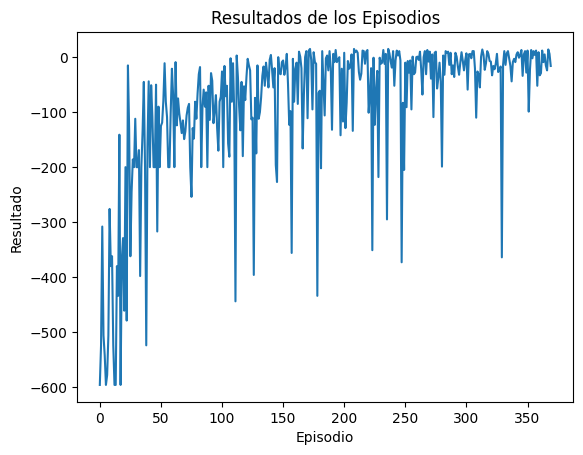

In [198]:
#-------------------------------------------------------------------------
# MOSTRAMOS EL NIVEL DE APRENDIZAJE DEL MODELO
#-------------------------------------------------------------------------
def dibujarValores( valores ):
    plt.plot( np.arange( len( valores ) ), valores )
    plt.title( 'Resultados de los Episodios' )
    plt.xlabel( 'Episodio' )
    plt.ylabel( 'Resultado' )
    plt.show()

dibujarValores( valores )

# **6.   Ejecutando el Agente**

La función run_agent está diseñada para ejecutar nuestro agente capacitado en el entorno Taxi-v3 y muestra su interacción.

*   agente.epsilon = 0: Esta línea establece la tasa de exploración (épsilon) del agente en cero, lo que indica que el agente debe explotar su política aprendida sin realizar más exploración.

*   El bucle while continúa hasta que el episodio termina (terminado == Verdadero) o la interacción se trunca (truncada == Verdadero)

*   accion = agente.obtenerAccion(estado): El agente selecciona una acción en función de su política aprendida.

*   entorno.render(): Representa el estado actualizado después de la acción del agente.

*   estado = siguienteEstado: Actualiza el estado actual al siguiente estado para la siguiente iteración.


In [199]:
#-------------------------------------------------------------------------
# MOSTRAMOS EL FUNCIONAMIENTO DEL AGENTE PARA LLEGAR AL OBJETIVO
#-------------------------------------------------------------------------
def ejecutarAgente( agente, entorno ):
    agente.epsilon = 0          # No necesita seguir explorando
    estado, _ = entorno.reset() # Obtiene el estado actual
    entorno.render()
    fin = exploracionTruncada = False

    while fin == False and exploracionTruncada == False   :
        accion = agente.obtenerAccion( estado )
        siguienteEstado, _, fin, exploracionTruncada, _ = entorno.step( accion )
        print( entorno.render() )
        estado = siguienteEstado

entorno = gym.make( 'Taxi-v3', render_mode = 'ansi' )
ejecutarAgente( agente, entorno )

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

